In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
%matplotlib inline
from patsy import dmatrix

In [3]:
# Read a dataset to practice - we are reading a dataset of people's wages along with their socio-economic attributes. 
wage = pd.read_csv('../data/Wage.csv', header=0, na_values='NA')
print(wage.shape)
wage.head()

(3000, 12)


,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


## Polynomial Regression

Now, We will learn how to fit a polynomial regression model on the wage dataset using sklearn package.

In [4]:
X = wage.age.to_numpy()
y = wage.wage.to_numpy()

X = X.reshape(X.shape[0], 1)
y = y.reshape(y.shape[0], 1)

reg = LinearRegression()
reg.fit((PolynomialFeatures(4).fit_transform(X)), y)

# get coefficients and compare with the numbers as the end of page 288.
print(reg.intercept_, reg.coef_)

[-184.15417975] [[ 0.00000000e+00  2.12455205e+01 -5.63859312e-01  6.81068771e-03
  -3.20383037e-05]]


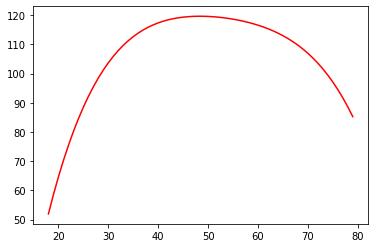

In [5]:
# generate a sequence of age values spanning the range & generate test data
age_grid = np.arange(wage.age.min(), wage.age.max()).reshape(-1,1)
X_test = PolynomialFeatures(4).fit_transform(age_grid)

# predict the value of the generated ages
y_pred = reg.predict(X_test)

# creating plots between age grid and predicted y (wage)
plt.plot(age_grid, y_pred, color='red')
plt.show()

### Decide on the polynomial to use. 

An alternate way used in the book for deciding on polynomial level is hypothesis testing though ANOVA using F-test. statsmodel.api has a built-in function to do that. 

In [6]:
X1 = PolynomialFeatures(1).fit_transform(X)
X2 = PolynomialFeatures(2).fit_transform(X)
X3 = PolynomialFeatures(3).fit_transform(X)
X4 = PolynomialFeatures(4).fit_transform(X)
X5 = PolynomialFeatures(5).fit_transform(X)
X6 = PolynomialFeatures(6).fit_transform(X)

fit1 = sm.GLS(y, X1).fit()
fit2 = sm.GLS(y, X2).fit()
fit3 = sm.GLS(y, X3).fit()
fit4 = sm.GLS(y, X4).fit()
fit5 = sm.GLS(y, X5).fit()
fit6 = sm.GLS(y, X6).fit()

In [7]:
print(sm.stats.anova_lm(fit1, fit2, fit3, fit4, fit5, fit6, type=1))

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.663571  2.285169e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.893609  1.674794e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.811683  5.098933e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.805371  3.695646e-01
5    2993.0  4.766389e+06      1.0    3932.257631    2.469216  1.162015e-01


As visible through p value, a cubic or a quartic polynomial seems to provide a good fit to the data, but lower or higher order models are not good enough in comparsion.

In the book, the authors also discussed logistic regression and the polynomial terms.

In [8]:
logistic_model = sm.GLM((y>250), X4, family=sm.families.Binomial())
logistic_fit = logistic_model.fit()
print(logistic_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -350.61
Date:                Sat, 02 Jul 2022   Deviance:                       701.22
Time:                        17:11:50   Pearson chi2:                 3.70e+03
No. Iterations:                    10   Pseudo R-squ. (CS):           0.009724
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -109.5530     47.655     -2.299      0.0

## Step/Piecewise-constant function
Using polynomial functions of the features as predictors in a linear model imposes a global structure on the non-linear function of X. We can instead use step functions in order to avoid imposing such a global structure. Here step function we break the range of X into bins, and fit a different constant in each bin. This amounts to converting a continuous variable into an ordered categorical variable.

Unfortunately, unless there are natural breakpoints in the predictors, piecewise-constant functions can miss the action.Nevertheless, step function approaches are very popular in biostatistics and epidemiology, among other disciplines. For example, 5-year age groups are often used to define the bins.

In order to fit a step function, we use the cut() function:

In [9]:
age_cut, bins = pd.cut(wage.age, bins=4, retbins=True, right=True)
age_cut.value_counts(sort=False)
print(age_cut)

0       (17.938, 33.5]
1       (17.938, 33.5]
2         (33.5, 49.0]
3         (33.5, 49.0]
4         (49.0, 64.5]
             ...      
2995      (33.5, 49.0]
2996    (17.938, 33.5]
2997    (17.938, 33.5]
2998    (17.938, 33.5]
2999      (49.0, 64.5]
Name: age, Length: 3000, dtype: category
Categories (4, interval[float64, right]): [(17.938, 33.5] < (33.5, 49.0] < (49.0, 64.5] < (64.5, 80.0]]


The cut() automatically picked the cutpoints at 33.5, 49, and 64.5 years of age but we could specify our own cut points too using the breaks option.

## Basis Functions

Both Polynomial and piecewise-constant regression models we practice above are in fact special cases of a basis function approach. The idea is to have at hand a family of functions or transformations that can be applied to a variable X: b1(X), b2(X),...,bK(X). Instead of fitting a linear model in X, we fit the model 

yi = β0 + β1b1(xi) + β2b2(xi) + β3b3(xi) + ... + βKbK(xi) + i. 

In the next section, we investigate a very common choice for a basis function: regression splines.

## Regression Splines

In regression splines, we fit a piecewise degree-d polynomial under the constraint that it (and possibly its first d − 1 derivatives) be continuous. 

In order to fit regression splines in python, we use the spatsy library. The regression splines can be fit by constructing an appropriate matrix of basis functions. The bs() function generates the entire matrix of bs() basis functions for splines with the specified set of knots.

Here we have prespecified knots at ages 25, 40, and 60. This produces a spline with six basis functions. 

In [31]:
age_grid = np.arange(wage.age.min(), wage.age.max()).reshape(-1,1)
print(wage.age.shape)
spline_basis1 = dmatrix("bs(wage.age, knots=(25,40,60), degree=3, include_intercept=False)", {"wage.age": wage.age}, return_type='dataframe')
spline_basis1

(3000,)


,Intercept,"bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]","bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]","bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]","bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]","bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]","bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]"
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1.0,0.559911,0.403778,0.033395,0.000000,0.000000,0.0
2,1.0,0.000000,0.114796,0.618564,0.262733,0.003906,0.0
3,1.0,0.000000,0.167109,0.633167,0.198880,0.000844,0.0
4,1.0,0.000000,0.034014,0.508194,0.426542,0.031250,0.0
...,...,...,...,...,...,...,...
2995,1.0,0.000000,0.139320,0.628472,0.230208,0.002000,0.0
2996,1.0,0.137741,0.629111,0.228819,0.004329,0.000000,0.0
2997,1.0,0.302617,0.586851,0.110255,0.000277,0.000000,0.0
2998,1.0,0.302617,0.586851,0.110255,0.000277,0.000000,0.0


In [32]:
spline_fit1 = sm.GLM(wage.wage, spline_basis1).fit()
spline_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2993
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                          1594.0
Method:                          IRLS   Log-Likelihood:                -15314.
Date:                Sat, 02 Jul 2022   Deviance:                   4.7708e+06
Time:                        16:58:44   Pearson chi2:                 4.77e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.09006
Covariance Type:            nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 60.4937      9.460      6.394      0.000      41.952      79.036
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]     3.9805     12.538      0.317      0.751     -20.593      28.554
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]    44.6310      9.626      4.636      0.000      25.764      63.498
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]    62.8388     10.755      5.843      0.000      41.759      83.919
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]    55.9908     10.706      5.230      0.000      35.007      76.975
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]    50.6881     14.402      3.520      0.000      22.461      78.915
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]    16.6061     19.126      0.868      0.385     -20.881      54.093
==========================================================================================================================================
"""

In [34]:
# Another approach is to fix the degree of freedom and let the code to automatically choose the knots.
spline_basis2 = dmatrix("bs(wage.age, df=6, include_intercept=False)",
                        {"wage.age": wage.age}, return_type='dataframe')
spline_fit2 = sm.GLM(wage.wage, spline_basis2).fit()
spline_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2993
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                          1592.5
Method:                          IRLS   Log-Likelihood:                -15313.
Date:                Sat, 02 Jul 2022   Deviance:                   4.7662e+06
Time:                        16:59:27   Pearson chi2:                 4.77e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.09101
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         56.3138      7.258      7.759      0.000      42.088      70.539
bs(wage.age, df=6, include_intercept=False)[0]    27.8240     12.435      2.238      0.025       3.453      52.195
bs(wage.age, df=6, include_intercept=False)[1]    54.0625      7.127      7.585      0.000      40.093      68.032
bs(wage.age, df=6, include_intercept=False)[2]    65.8284      8.323      7.909      0.000      49.515      82.142
bs(wage.age, df=6, include_intercept=False)[3]    55.8127      8.724      6.398      0.000      38.714      72.911
bs(wage.age, df=6, include_intercept=False)[4]    72.1315     13.745      5.248      0.000      45.192      99.071
bs(wage.age, df=6, include_intercept=False)[5]    14.7509     16.209      0.910      0.363     -17.018      46.519
==================================================================================================================
"""

## Smoothing Splines

Instead of specifying a set of knots, in smooth spines, we are fitting a smooth curve to a set of data, what we really want to do is find some function, say g(x), that fits the observed data well: that is, we
want RSS to be small.

In [38]:
# Package patsy also has a nice function to do natural spline, cr()
spline_basis3 = dmatrix("cr(wage.age, df=4)", {"wage.age": wage.age}, return_type='dataframe')
spline_fit3 = sm.GLM(wage.wage, spline_basis3).fit()
spline_fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2996
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          1596.4
Method:                          IRLS   Log-Likelihood:                -15318.
Date:                Sat, 02 Jul 2022   Deviance:                   4.7827e+06
Time:                        17:00:07   Pearson chi2:                 4.78e+06
No. Iterations:                     4   Pseudo R-squ. (CS):            0.08766
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                79.6421      1.773     44.918      0.000      76.167      83.117
cr(wage.age, df=4)[0]   -14.6678      3.436     -4.269      0.000     -21.402      -7.934
cr(wage.age, df=4)[1]    36.8111      1.950     18.881      0.000      32.990      40.632
cr(wage.age, df=4)[2]    35.9349      2.056     17.476      0.000      31.905      39.965
cr(wage.age, df=4)[3]    21.5639      6.989      3.085      0.002       7.865      35.263
=========================================================================================
"""

In [39]:
# Finally, let us makesome predictions
pred1 = spline_fit1.predict(dmatrix("bs(age_grid, knots=(25,40,60), include_intercept=False)",{"age_grid": age_grid}, return_type='dataframe'))
pred2 = spline_fit2.predict(dmatrix("bs(age_grid, df=6, include_intercept=False)",{"age_grid": age_grid}, return_type='dataframe'))
pred3 = spline_fit3.predict(dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe'))

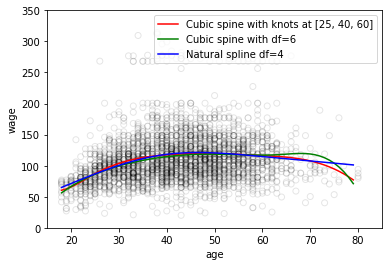

In [41]:
# Plot the splines and error bands
plt.scatter(wage.age, wage.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, pred1, color='r', label='Cubic spine with knots at [25, 40, 60]')
plt.plot(age_grid, pred2, color='g', label='Cubic spine with df=6')
plt.plot(age_grid, pred3, color='b', label='Natural spline df=4')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')
plt.show()

## GAMs

Untill now, we saw a number of approaches for flexibly predicting a response Y on the basis of a single predictor X. These approaches can be seen as extensions of simple linear regression. Here we explore the problem of predicting Y on the basis of several predictors, X1,...,Xp.This amounts to an extension of multiple linear regression. 

Generalized additive models (GAMs) provide a general framework for generalized additive model extending a standard linear model by allowing non-linear functions of each of the variables, while maintaining additivity. Just like linear models, GAMs additivity can be applied with both quantitative and qualitative responses. 

In [47]:
# Here we construct the basis of all the perdictors. 
age_basis = dmatrix("cr(wage.age, df=5)", {"wage.age": wage.age}, return_type='dataframe')
year_basis = dmatrix("cr(wage.year, df=4)", {"wage.year": wage.year}, return_type='dataframe').drop (['Intercept'], axis = 1)
education_dummies = pd.get_dummies(wage.education)
education_dummies = education_dummies.drop([education_dummies.columns[0]], axis = 1)

x_all = pd.concat([age_basis, year_basis, education_dummies], axis=1)

gam1_fit = sm.OLS(wage.wage, x_all).fit()
gam1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     111.8
Date:                Sat, 02 Jul 2022   Prob (F-statistic):          2.63e-214
Time:                        17:07:33   Log-Likelihood:                -14933.
No. Observations:                3000   AIC:                         2.989e+04
Df Residuals:                    2988   BIC:                         2.996e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 52.0059      2.009     25.892      0.000      48.068      55.944
cr(wage.age, df=5)[0]    -19.1099      3.298     -5.795      0.000     -25.576     -12.644
cr(wage.age, df=5)[1]     18.6087      2.336      7.967      0.000      14.029      23.188
cr(wage.age, df=5)[2]     27.4048      1.986     13.800      0.000      23.511      31.298
cr(wage.age, df=5)[3]     22.3674      2.535      8.822      0.000      17.396      27.339
cr(wage.age, df=5)[4]      2.7349      7.927      0.345      0.730     -12.807      18.277
cr(wage.year, df=4)[0]     8.5675      1.375      6.232      0.000       5.872      11.263
cr(wage.year, df=4)[1]    12.9712      1.269     10.223      0.000      10.483      15.459
cr(wage.year, df=4)[2]    14.5819      1.309     11.139      0.000      12.015      17.149
cr(wage.year, df=4)[3]    15.8853      1.528     10.398      0.000      12.890      18.881
2. HS Grad                10.7858      2.431      4.438      0.000       6.020      15.551
3. Some College           23.1820      2.560      9.055      0.000      18.162      28.202
4. College Grad           37.8598      2.543     14.889      0.000      32.874      42.846
5. Advanced Degree        62.3017      2.762     22.556      0.000      56.886      67.717
==============================================================================
Omnibus:                     1040.588   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5586.798
Skew:                           1.557   Prob(JB):                         0.00
Kurtosis:                       8.916   Cond. No.                     2.02e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.37e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""